In [2]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import numpy as np
import pandas as pd
import seaborn as sns
import joblib

From the trained models we will extract feature importance scores from both waves. We will select all metabolites that were used during training (the number of metabolites that were used during training was determined by correlation analysis)

In [3]:
depression_model_wave1 = joblib.load("models/imputed_depression_model.pkl")
met_syndrome_model_wave1 = joblib.load("models/met_syndrome_model.pkl")
depression_model_wave5 = joblib.load("models/depression_model_wave5.pkl")
met_syndrome_model_wave5 = joblib.load("models/met_syndrome_model_wave5.pkl")

def get_feature_importance_based_on_gain(model):
    feature_importance = model.feature_importances_
    feature_names = model.get_booster().feature_names
    importance = pd.Series(feature_importance, index=feature_names).sort_values(ascending=False)
    return importance

depression_importance_wave1 = get_feature_importance_based_on_gain(depression_model_wave1)
met_syndrome_importance_wave1 = get_feature_importance_based_on_gain(met_syndrome_model_wave1)
depression_importance_wave5 = get_feature_importance_based_on_gain(depression_model_wave5)
met_syndrome_importance_wave5 = get_feature_importance_based_on_gain(met_syndrome_model_wave5)

shared_metabolites_wave1 = set(depression_importance_wave1.index) & set(met_syndrome_importance_wave1 .index)
shared_metabolites_wave5 = set(depression_importance_wave5.index) & set(met_syndrome_importance_wave5 .index)

Because the column names in wave1 and wave5 are different, we need to map it to find the shared metabolites found in both waves

In [50]:
def map_and_find_shared(var1, var2):
    mapping = {v.replace('a', 'e').replace('_', ''): v for v in var1}
    var2_set = set(var2)
    shared = [mapping[v2] for v2 in var2 if v2 in mapping]

    return shared


shared_metabolites = map_and_find_shared(shared_metabolites_wave1, shared_metabolites_wave5)
print("Shared metabolites:", shared_metabolites)
print(len(shared_metabolites))


Shared metabolites: ['aL_VLDL_FC', 'aIle', 'aL_VLDL_L', 'aGlc', 'aXXL_VLDL_CE', 'aXL_VLDL_PL', 'aXL_VLDL_FC', 'aXL_HDL_FC', 'aS_LDL_TG', 'aXS_VLDL_TG', 'aXL_HDL_C', 'aL_VLDL_CE', 'aIDL_TG', 'aHDL_TG', 'aM_HDL_TG', 'aS_VLDL_C', 'aM_VLDL_C', 'aXXL_VLDL_TG', 'aVLDL_D', 'aXL_VLDL_C', 'aLeu', 'aL_VLDL_TG', 'aHDL2_C', 'aXXL_VLDL_C', 'aS_VLDL_PL', 'aSerum_TG', 'aXXL_VLDL_PL', 'aL_HDL_L', 'aHDL_D', 'aVLDL_TG', 'aS_VLDL_L', 'aL_HDL_FC', 'aL_VLDL_PL', 'aS_HDL_TG', 'aTotFA', 'aXL_HDL_L', 'aXL_VLDL_TG', 'aS_VLDL_TG', 'aL_HDL_C', 'aXXL_VLDL_FC', 'aS_VLDL_FC', 'aTyr', 'aL_VLDL_C', 'aM_VLDL_L', 'aVLDL_C', 'aHDL_C', 'aS_VLDL_CE', 'aL_HDL_CE', 'aM_VLDL_TG', 'aApoB', 'aXL_VLDL_L', 'aM_VLDL_FC', 'aXXL_VLDL_L', 'aXL_HDL_PL', 'aXL_VLDL_CE', 'aM_VLDL_PL', 'aL_HDL_PL', 'aGp', 'aM_VLDL_CE', 'aSFA', 'aMUFA']
61


In [20]:
experts_opinion_wave1 = ['aHDL_C', 'aLDL_C', 'aSerum_C', 'aSerum_TG', 'aLDL_TG', 'aApoA1', 'aApoB', 'aTotFA', 'aIle', 'aGp']
experts_opinion_wave5 = ['eHDLC', 'eLDLeC', 'eSerumC', 'eSerumTG', 'eLDLTG', 'eApoA1', 'eApoB', 'eTotFA', 'eIle', 'eGp']
result_wave1 = list(set(shared_metabolites_wave1)&set(experts_opinion_wave1))
result_wave5 = list(set(shared_metabolites_wave5)&set(experts_opinion_wave5))
both_waves = list(set(shared_metabolites)&set(experts_opinion_wave1))
print(f"[Wave 1] shared metabolites with expert opinions: {result_wave1} within {len(depression_importance_wave1)} metabolites")
print(f"[Wave 5] shared metabolites with expert opinions: {result_wave5} within {len(depression_importance_wave5)} metabolites")
print(f"Shared metabolites in both waves with expert opinions: {both_waves}")

[Wave 1] shared metabolites with expert opinions: ['aApoB', 'aHDL_C', 'aTotFA', 'aLDL_TG', 'aSerum_TG', 'aIle', 'aGp'] within 104 metabolites
[Wave 5] shared metabolites with expert opinions: ['eHDLC', 'eIle', 'eSerumTG', 'eApoB', 'eGp', 'eApoA1', 'eTotFA'] within 121 metabolites
Shared metabolites in both waves with expert opinions: ['aApoB', 'aHDL_C', 'aTotFA', 'aSerum_TG', 'aIle', 'aGp']


Here we plot the ranking importance of the shared metabolites (found in both waves) for each wave

In [53]:
def plot_importance_ranking(shared_metabolites, depression_importance, met_syndrome_importance, wave_number):
    shared_importance = pd.DataFrame({
        'Depression_Importance': depression_importance.loc[shared_metabolites],
        'Met_Syndrome_Importance': met_syndrome_importance.loc[shared_metabolites],
    })
    shared_importance['Importance'] = shared_importance.mean(axis=1)
    ranked_shared_importance = shared_importance.sort_values(by='Importance', ascending=False)

    fig, ax = plt.subplots(figsize=(20, 14))
    ranked_shared_importance[['Importance']].plot(kind='barh', ax=ax, color='#87BFFF', legend=False)
    ax.set_title(f'Ranking of Shared Metabolites Found in Both Waves by Average Importance in Wave {wave_number}')
    ax.invert_yaxis()
    ax.set_xticks([])

    for i in ax.patches:
        ax.text(i.get_width() + max(0.001, i.get_width() * 0.1), i.get_y() + i.get_height() / 2,
                str(round(i.get_width(), 4)),
                fontsize=10, fontweight='bold',
                color='grey', verticalalignment='center')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    
    plt.show()

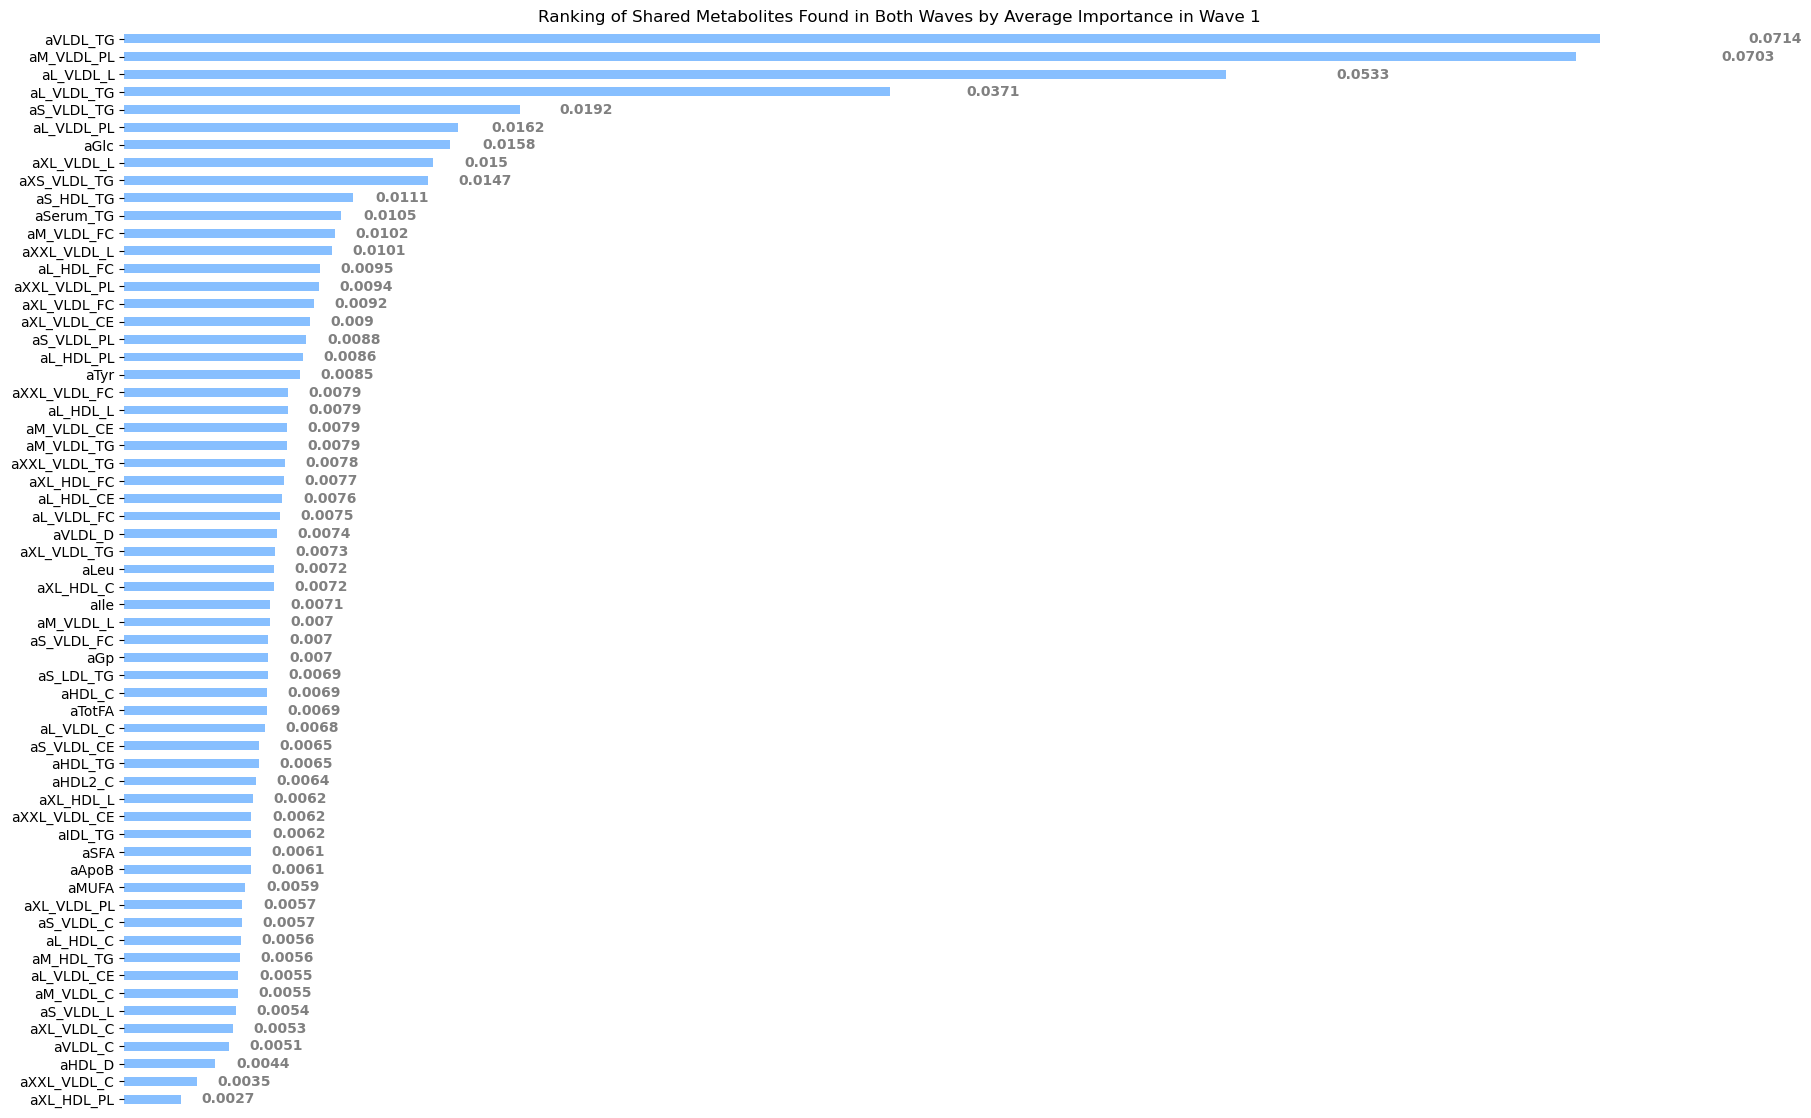

In [54]:
plot_importance_ranking(shared_metabolites, depression_importance_wave1, met_syndrome_importance_wave1, 1)

In [31]:
def map_wave1_to_wave5(names):
    return [name.replace('a', 'e').replace('_', '') for name in names]

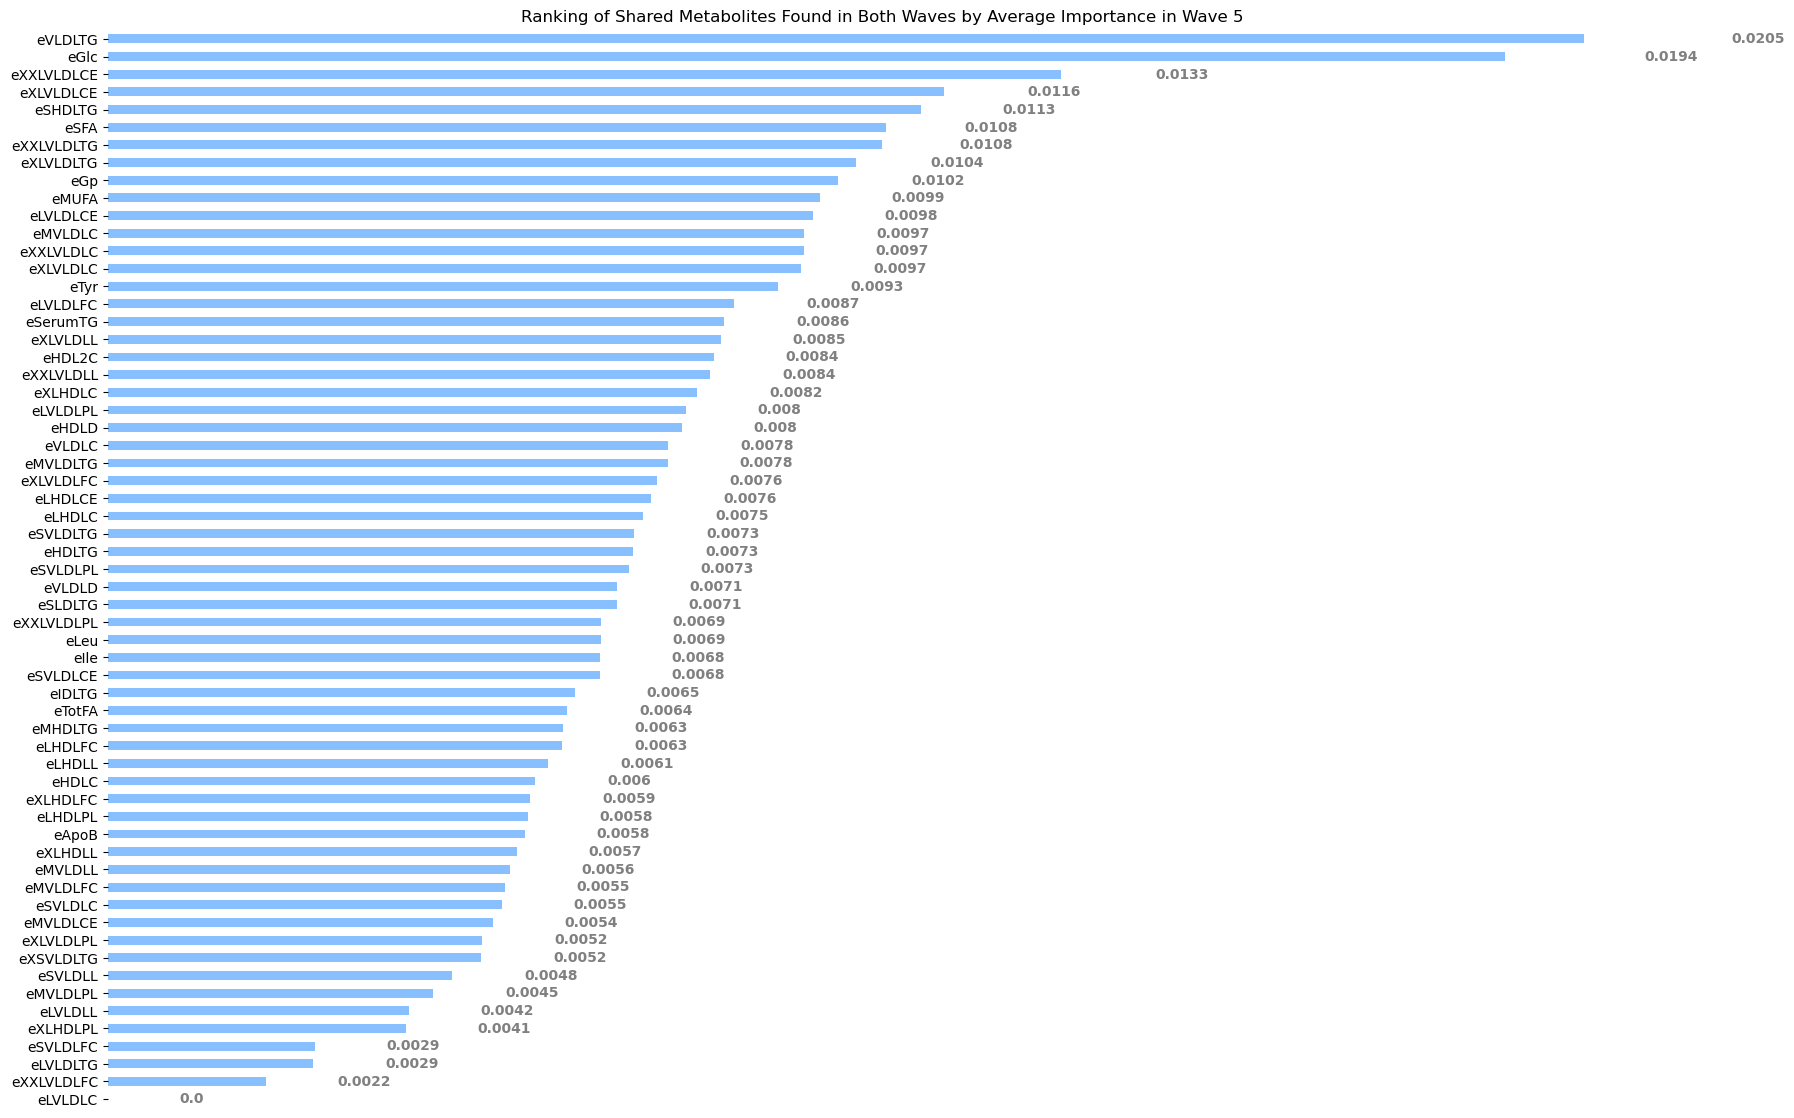

In [55]:
mapped_shared_metabolites = map_wave1_to_wave5(shared_metabolites)
plot_importance_ranking(mapped_shared_metabolites, depression_importance_wave5, met_syndrome_importance_wave5, 5)

There are 61 shared metabolites found in both waves, we need to narrow this down further by ranking the most important features to a certain number

In [38]:
def get_top_metabolites(shared_metabolites, depression_importance, met_syndrome_importance, rank_num):
    shared_importance = pd.DataFrame({
        'Depression_Importance': depression_importance.loc[shared_metabolites],
        'Met_Syndrome_Importance': met_syndrome_importance.loc[shared_metabolites],
    })
    shared_importance['Importance'] = shared_importance.mean(axis=1)
    ranked_shared_importance = shared_importance.sort_values(by='Importance', ascending=False)

    return ranked_shared_importance[:rank_num].index

In [80]:
top_wave1 = get_top_metabolites(shared_metabolites, depression_importance_wave1, met_syndrome_importance_wave1, 20)
top_wave5 = get_top_metabolites(mapped_shared_metabolites, depression_importance_wave5, met_syndrome_importance_wave5, 20)

In [81]:
mapped_column_names_in_wave1 = map_wave1_to_wave5(top_wave1)
shared_metabolites_both_waves = set(mapped_column_names_in_wave1) & set(top_wave5)
unique_wave1 = set(mapped_column_names_in_wave1) - shared_metabolites_both_waves
unique_wave5 = set(top_wave5) - shared_metabolites_both_waves

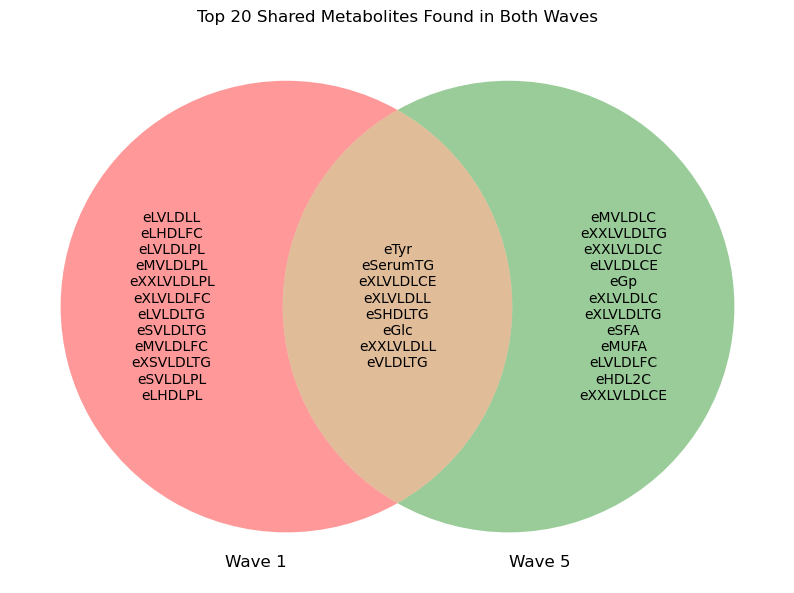

In [83]:
plt.figure(figsize=(10, 10))
venn_diagram = venn2([unique_wave1 | shared_metabolites_both_waves, unique_wave5 | shared_metabolites_both_waves], ('Wave 1', 'Wave 5'))
venn_diagram.get_label_by_id('10').set_text('\n'.join(unique_wave1))
venn_diagram.get_label_by_id('01').set_text('\n'.join(unique_wave5))
venn_diagram.get_label_by_id('11').set_text('\n'.join(shared_metabolites_both_waves))
plt.title("Top 20 Shared Metabolites Found in Both Waves")
plt.show()

In [78]:
set(shared_metabolites_both_waves)&set(experts_opinion_wave5)

{'eSerumTG'}